<a href="https://colab.research.google.com/github/AlejandroVillazonG/MAT468/blob/main/labs/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Taller 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.neighbors import NearestNeighbors

Dado un conjunto de puntos $S\subseteq \mathbb{R}^2$, se define la siguiente función de densidad:

$$f(x) = \frac{1}{c} \sum_{s\in S}\exp{(-\phi(x-s))}, \quad x\in[0,1]\times[0,1]$$

Con $\phi$ una función creciente tal que $\phi(0)=0$. En lo que sigue asuma que $\phi(x-s) = \psi\|x-s\|$ con $\psi>0$. El objetivo del taller es usar el algoritmo de aceptación rechazo para simular puntos de la densidad anterior, para lo cual se propone el siguiente procedimiento:

## 1. Genere aleatoriamente $S$ con $|S|=n$.

In [2]:
n = 100
S = np.column_stack((np.random.uniform(0,1,n), np.random.uniform(0,1,n)))

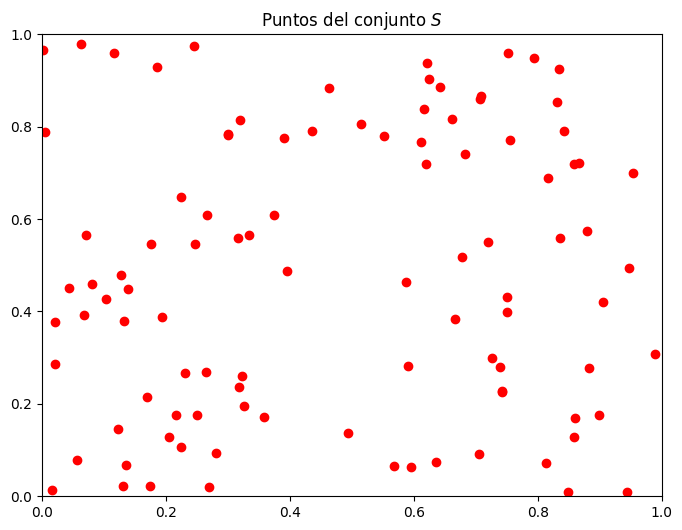

In [3]:
plt.figure(figsize=(8,6))
plt.scatter(S[:,0], S[:,1], c = 'red')
plt.title(r'Puntos del conjunto $S$')
plt.xlim(0,1); plt.ylim(0,1)
plt.show()

Definimos la función $f$ que depende del conjunto $S$ sin la constante normalizadora $c$.

In [4]:
psi = 1/0.05
f_ = lambda x: np.sum(np.exp(- psi * distance_matrix(S, x.reshape(1,2))))

Generamos la malla para evaluar la función $f$ y calcular $c$.

<!--

plt.figure(figsize=(8,6))
plt.scatter(S[:,0], S[:,1], c = 'red',
            label = 'Puntos de S',
            zorder = 1)
plt.scatter(malla[:,0], malla[:,1],
            alpha=0.5, c = 'blue',
            label = 'Puntos de la malla',
            zorder = 0)
plt.xlim(0,1); plt.ylim(0,1)
plt.legend();

 -->

In [5]:
a = 0
b = 1
n_malla = 500

x = np.linspace(a, b, n_malla)
XX, YY = np.meshgrid(x, x)
malla = np.column_stack((XX.flatten(), YY.flatten())) #Ordenados de izq a der y de abajo hacia arriba

## 2. Calcule numéricamente la constante $c$.

In [6]:
c = 0

for punto in malla:
    c += f_(punto)

c *= ((b-a)/n_malla) ** 2

c

1.3704586527222666

In [7]:
f = lambda x: f_(x)/c

Grafiquemos las curvas de nivel de la densidad $f$ en los puntos de la malla.

In [8]:
f_x = np.array([f(x) for x in malla])

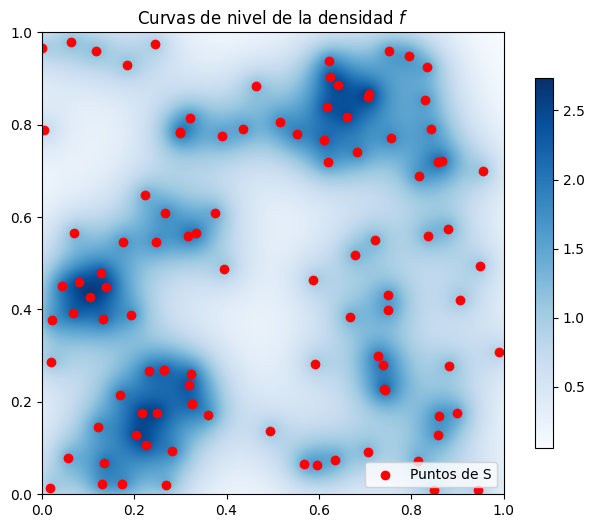

In [9]:
plt.figure(figsize=(8,6))

#Puntos de S
plt.scatter(S[:,0], S[:,1], c = 'red',
            label = 'Puntos de S',
            zorder = 1)
# Curvas de nivel de f
plt.imshow(f_x.reshape(n_malla,n_malla),
           origin = 'lower',
           cmap = 'Blues',
           extent = [0,1,0,1])
plt.colorbar(shrink=0.8)
plt.title(r'Curvas de nivel de la densidad $f$')
plt.legend();

## 3. Con el método aceptación rechazo, simule puntos de la densidad anterior usando de distribución instrumental una distribución uniforme en el cuadrado $[0,1]$.

In [10]:
N = 100_000

M = max([f(s) for s in S])

def g(x,sim = False):
    if sim == True: # Simular de g
        return np.random.uniform(0,1,(1,2))
    return 1

In [11]:
def acept_rechazo(N, M, f, g, flag = False):
    n = 0
    nro_rechazados = 0
    aceptados = []
    while n<N:
        u = np.random.uniform(0,1)
        y = g(0,sim = True)
        if u <= f(y)/(M*g(y)):
            aceptados.append(y)
            n += 1
        else:
            nro_rechazados +=1
    return np.vstack(aceptados) if flag == False else (np.vstack(aceptados), nro_rechazados)

In [12]:
simulaciones, nro_rechazados = acept_rechazo(N, M, f, g, True)

Grafiquemos el histograma 2D de las simulaciones obtenidas.

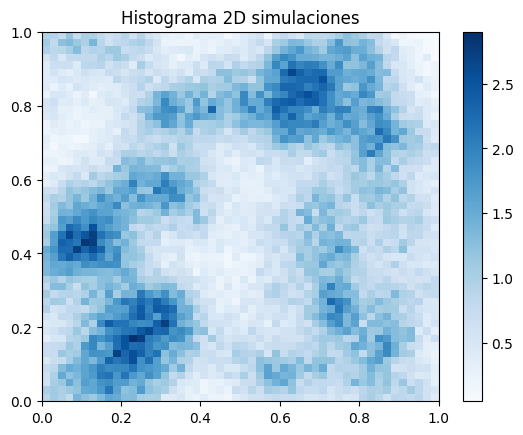

In [13]:
plt.hist2d(simulaciones[:, 0], simulaciones[:, 1],
           bins = 50, cmap='Blues', density = True,
           range=[[0, 1], [0, 1]])
plt.colorbar()
plt.title('Histograma 2D simulaciones');

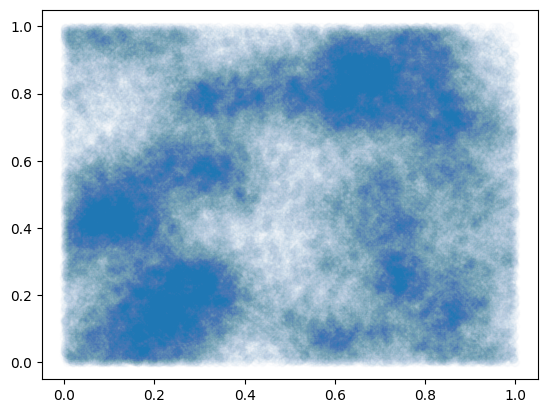

In [14]:
plt.scatter(simulaciones[:, 0], simulaciones[:, 1],
            alpha = 0.01 # nivel de opacidad de los puntos
            );

In [15]:
nro_rechazados

172877

In [16]:
# Tasa de aceptación
1 - nro_rechazados / (N + nro_rechazados)

0.366465477119728

In [17]:
1 / M

0.3651849128917445

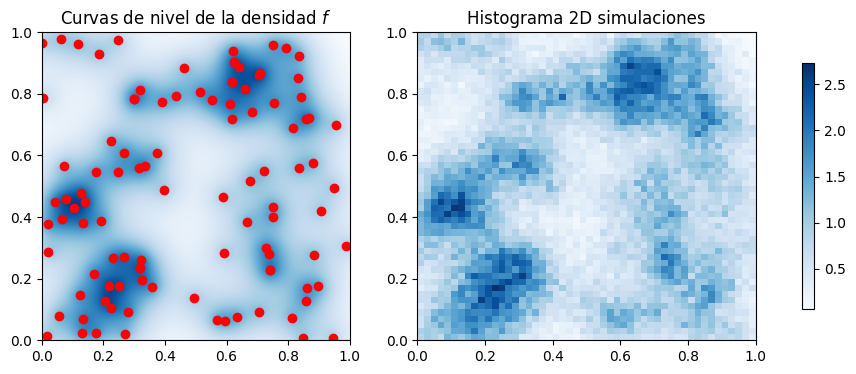

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axs[1].hist2d(simulaciones[:, 0], simulaciones[:, 1],
              bins = 50, cmap='Blues', density = True)
axs[1].set(xlim=(0, 1), ylim=(0, 1))
axs[1].set_title('Histograma 2D simulaciones')

axs[0].scatter(S[:,0], S[:,1],
               c = 'red',
               label = 'Puntos de S',
               zorder = 1)
im = axs[0].imshow(f_x.reshape(n_malla,n_malla),
                   origin = 'lower',
                   cmap = 'Blues',
                   extent = [0,1,0,1])
axs[0].set_title(r'Curvas de nivel de la densidad $f$')


fig.colorbar(im, ax=axs, shrink=0.8)
plt.show()

## 4. Para acelerar el proceso simule usando el método aceptación rechazo con envolturas. Para lo anterior considere la densidad:

## $$g_L(x) = \frac{1}{c} \sum_{s\in S_x(k)} \exp{(-\psi\|x-s\|)}, \quad x\in[0,1]\times[0,1]$$

## En donde $S_x(k)$ es el conjunto de los $k$ vecinos más cercanos de $S$ al punto $x$.

In [19]:
k = 30

neighbors = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(S)

def g_L(x):
    # Encontrar los indices de los k vecinos más cercanos al punto x
    indices = neighbors.kneighbors(x, return_distance=False)[0]
    S_x = S[indices]
    return np.sum(np.exp(-psi*distance_matrix(S_x, x.reshape(1,2)))) / c

In [20]:
# ejemplo
x = g(0,sim = True)

indices = neighbors.kneighbors(x, return_distance=False)[0]
print(f'{indices = }')

S_x = S[indices]
S_x

indices = array([63, 67, 64, 80, 91, 72, 39, 66, 30, 35, 58, 94, 57,  9, 95, 26, 81,
       53, 47, 78,  1, 14, 18, 51,  6, 41, 29,  2, 11, 65])


array([[0.74235808, 0.2267691 ],
       [0.74185546, 0.22800015],
       [0.73856175, 0.27969999],
       [0.86030034, 0.16918965],
       [0.88253715, 0.27791495],
       [0.72699684, 0.30002659],
       [0.89840704, 0.17534367],
       [0.85856205, 0.12767962],
       [0.81355453, 0.07283821],
       [0.70560609, 0.09187452],
       [0.75059443, 0.39927563],
       [0.66716652, 0.38410978],
       [0.75043973, 0.43147666],
       [0.98939848, 0.30703489],
       [0.5913603 , 0.28291338],
       [0.90587358, 0.42108621],
       [0.63521696, 0.07480702],
       [0.84901977, 0.00893464],
       [0.59494774, 0.06284178],
       [0.94424918, 0.00898799],
       [0.56873505, 0.06498804],
       [0.94795757, 0.49464441],
       [0.67706386, 0.51870326],
       [0.5882481 , 0.46414938],
       [0.49415549, 0.13648997],
       [0.72042031, 0.55116015],
       [0.83589587, 0.55858469],
       [0.88020531, 0.57524668],
       [0.359246  , 0.17267175],
       [0.81676479, 0.68812628]])

In [21]:
g_L(x)

1.2744272764948594

In [22]:
def acept_rechazo_slopes(N, M, f, g_M, g_L, flag=False):
    '''
    Implementa el método de aceptación-rechazo con envolturas para generar N simulaciones de la función f.

    Parameters
    ----------
    N : int
        Número de simulaciones deseadas.
    M : float or int
        Valor que acota f/g_M.
    f : function
        Función objetivo que se desea simular. Debe tomar un solo argumento.
    g_M : function
        Función de densidad, debe permitir evaluar o simular con sim=True.
    g_L : function
        Función que acota inferiormente a la función f. Debe tomar un solo argumento.
    flag : bool, optional
        Si es True, se retorna una tupla con:
            Las simulaciones
            Número de simulaciones aceptadas en primera oportunidad
            Número de simulaciones aceptadas en segunda oportunidad
            Número de simulaciones rechazadas
        Si es False (por defecto), se devuelven solo las simulaciones aceptadas.

    Returns
    -------
    _ : tuple
        Tupla con las simulaciones,
            Número de simulaciones aceptadas en primera oportunidad
            Número de simulaciones aceptadas en segunda oportunidad
            Número de simulaciones rechazadas
        en caso flag = True.
    or
    _ : array
        Array de simulaciones aceptadas en el caso de flag = False.
        Tupla con simluaciones, cantidad de aceptados en cada oportunidad y rechazados en caso flag = True.
    '''
    n_1 = n_2 = nro_rechazados = 0
    aceptados = []
    while (n_1 + n_2) <N:
        u = np.random.uniform(0,1)
        y = g_M(0,sim = True)

        if u <= g_L(y)/(M*g_M(y)):
            aceptados.append(y)
            n_1 += 1
        elif u <= f(y)/(M*g_M(y)):
            aceptados.append(y)
            n_2 += 1
        else:
            nro_rechazados += 1
    return np.vstack(aceptados) if flag == False else (np.vstack(aceptados), n_1, n_2, nro_rechazados)

In [23]:
N = 100_000

sim_slopes, n_1, n_2, nro_rechazados = acept_rechazo_slopes(N, M, f, g, g_L, True)

In [24]:
n_1 # Aceptados comparando con g_L

99566

In [25]:
n_2 # Aceptados comparando con f

434

In [26]:
nro_rechazados

172560

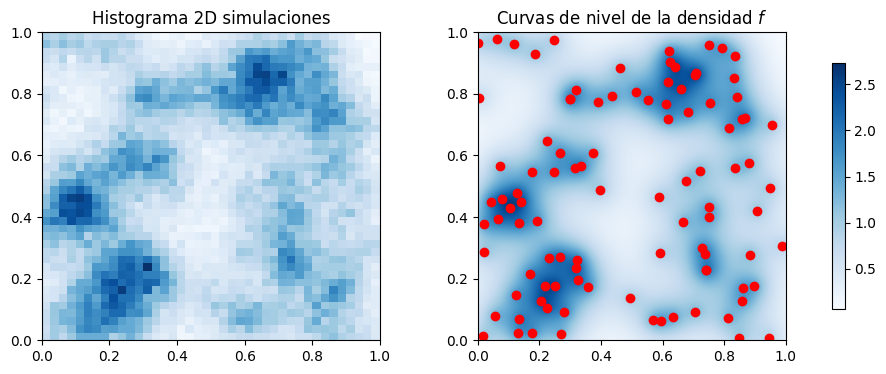

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axs[0].hist2d(sim_slopes[:, 0], sim_slopes[:, 1],
              bins = 40, cmap='Blues', density = True)
axs[0].set(xlim=(0, 1), ylim=(0, 1))
axs[0].set_title('Histograma 2D simulaciones')

axs[1].scatter(S[:,0], S[:,1],
               c = 'red',
               label = 'Puntos de S',
               zorder = 1)
im = axs[1].imshow(f_x.reshape(n_malla,n_malla),
                   origin = 'lower',
                   cmap = 'Blues',
                   extent = [0,1,0,1])
axs[1].set_title(r'Curvas de nivel de la densidad $f$')


fig.colorbar(im, ax=axs, shrink=0.8)
plt.show()